#Excercise 3
Neta Konsens - 316536275 </br>
Eden Harel - 205518178

#Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, models, transforms
import torch
from matplotlib import pyplot as plt
import os
from cv2 import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch.optim as optim
import torch.nn as nn
import tqdm
import seaborn as sn
import albumentations as A
from albumentations.augmentations.transforms import HorizontalFlip
from itertools import chain

Import drive

In [2]:
from google.colab import drive  
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Get images path from google drive

In [3]:
def get_images_path(folder_path ='/content/drive/MyDrive/Afeka_FaceData2022'):
  data_paths = []
  images_paths = []
  [data_paths.append(x[0]) for x in os.walk(folder_path)]
  labels = []
  for path in data_paths:
    labels.append(path.split("/")[-1]) 
  labels.remove(labels[0])

  for data_path in data_paths:
    images_paths.extend([glob.glob(os.path.join(data_path, d, "*.*")) for d in os.listdir(data_path)])
    
  return list(chain.from_iterable(images_paths)), labels

In [4]:
data_paths, labels = get_images_path()
print(len(data_paths))
print(labels)

260
['Johnny Depp', 'Amber Heard', 'Cristiano Ronaldo', 'Luka Doncic', 'Channing Tatum', 'Lionel Messi', 'Ronaldinho', 'Shahar Hason', 'Morgan Freeman', 'Lando Norris', 'Freddie Mercury', 'Natty Zepko', 'Cellian Murphy']


# Dataloader
loads one image at a time, used with an iterator

In [5]:
class MyDataset(Dataset): 
    def __init__(self, paths, labels, transform=None, train=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        p = self.paths[idx]
        label = p.split("/")[-2]
        label = self.labels.index(label)
        image = cv2.imread(p)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #image = cv2.resize(image, (224, 224),interpolation = cv2.INTER_AREA)
        
        #image = cv2.normalize(image.astype('float'),None,0.0,1.1,cv2.NORM_MINMAX)

        if self.transform:
          image = self.transform(image=image)['image']

        image = image.transpose(2,0,1)
        image = torch.from_numpy(image).float()
        

        return image, label # label count starts from zero not 1 

Albumentations implementation with the following facial detecion augmentations: </br>
1. Horizontal Flip
2. Random Contrast
3. Resize to 244,244
</br>
We chose these augmentations because they help us enrich the dataset while not changing the image too drastically.

In [6]:
transform = A.Compose([ 
    A.HorizontalFlip(p = 0.4),
    A.RandomContrast(p=0.3),
    A.Resize(224,224)
])

Augmentations examples:

Data splitter - splitting the data into 80% train dataset and 20% validastion dataset.

In [7]:
class load_data():
  def __init__(self, data_set):
    self.train, self.test = torch.utils.data.random_split(data_set, [int(len(data_set)*0.8), len(data_set)-int(len(data_set)*0.8)])
    self.train_loader = DataLoader(self.train, batch_size=16, shuffle=True)
    self.test_loader = DataLoader(self.test, batch_size=16, shuffle=False)

  def __call__(self):
    return self.train_loader, self.test_loader

In [8]:
data_set = MyDataset(data_paths, labels, transform=transform, train=True)
data = load_data(data_set)
train_loader, test_loader = data()

# VGG16

Our implementation for VGG16Net using pytorch

In [9]:
import torch.nn.functional as F

In [10]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(25088, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 13)

        self.activation = nn.Softmax(dim = 1)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, 0.5)
        x = self.fc3(x)
        #return self.activation(x)
        return x

In [35]:
model = VGG16()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #The most common optimizer for this task.

In [10]:
loss = nn.CrossEntropyLoss() # A loss function that fits a classification task.

In [13]:
from sklearn.metrics import accuracy_score


In [11]:
from tqdm import tqdm

In [12]:
def train_model(model,train_loader,test_loader,optimizer,lossFn,num_epoch = 30,DEVICE = 'cuda'):

  model = model.cuda()
  train_loss =[]
  total_train_loss = []
  total_test_acc = []
  test_acc = []

  for epoch in range(num_epoch):
    print(f"EPOCH #{epoch+1}")
    tq_train = tqdm(train_loader)

    model.train()
    for img, label in tq_train:
      if epoch==18:
        for param_group in optimizer.param_groups:
          param_group['lr'] = 0.00001

      img = img.cuda()
      label = label.cuda()
      optimizer.zero_grad()
      output = model(img)
      loss = lossFn(output,label)
      loss.backward()
      optimizer.step()

      train_loss.append(loss)
      tq_train.set_description(f"train loss = {sum(train_loss)/len(train_loss)}")
    model.eval()
    tq_test = tqdm(test_loader)


    with torch.no_grad():
      correct = 0
      samples = 0
      for img, label in tq_test:
        img = img.cuda()
        label = label.cuda()
        output = model(img)
        _,preds = torch.max(output,1)
        for i in range(len(preds)):
          if preds[i]==label[i]:
            correct = correct+1
        samples += preds.size(0)
        test_acc.append(float(correct) / float(samples) * 100)
        tq_test.set_description(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")

    total_train_loss.append(sum(train_loss)/len(train_loss))
    total_test_acc.append(sum(test_acc)/len(test_acc))
    train_loss =[]
    test_acc = []
  return total_train_loss,total_test_acc
  


Training our model

In [37]:
total_train_loss , total_test_acc = train_model(model,train_loader,test_loader,optimizer,loss)

EPOCH #1


train loss = 2.5700411796569824: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
accuracy 3.85 percentage || Correct 2 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]


EPOCH #2


train loss = 2.563967227935791: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
accuracy 3.85 percentage || Correct 2 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


EPOCH #3


train loss = 2.5700325965881348: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
accuracy 1.92 percentage || Correct 1 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.59it/s]


EPOCH #4


train loss = 2.56360125541687: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 1.92 percentage || Correct 1 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


EPOCH #5


train loss = 2.563587188720703: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 1.92 percentage || Correct 1 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


EPOCH #6


train loss = 2.5634255409240723: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 1.92 percentage || Correct 1 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


EPOCH #7


train loss = 2.5625381469726562: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
accuracy 7.69 percentage || Correct 4 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


EPOCH #8


train loss = 2.56158447265625: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
accuracy 3.85 percentage || Correct 2 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.57it/s]


EPOCH #9


train loss = 2.556854248046875: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]
accuracy 1.92 percentage || Correct 1 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


EPOCH #10


train loss = 2.563004732131958: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
accuracy 1.92 percentage || Correct 1 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


EPOCH #11


train loss = 2.5611484050750732: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
accuracy 1.92 percentage || Correct 1 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


EPOCH #12


train loss = 2.5581612586975098: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
accuracy 5.77 percentage || Correct 3 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


EPOCH #13


train loss = 2.519256591796875: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
accuracy 9.62 percentage || Correct 5 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


EPOCH #14


train loss = 2.477285623550415: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
accuracy 13.46 percentage || Correct 7 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


EPOCH #15


train loss = 2.3951261043548584: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
accuracy 13.46 percentage || Correct 7 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]


EPOCH #16


train loss = 2.2872750759124756: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
accuracy 21.15 percentage || Correct 11 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


EPOCH #17


train loss = 2.121171474456787: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 11.54 percentage || Correct 6 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


EPOCH #18


train loss = 1.9840134382247925: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 13.46 percentage || Correct 7 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.78it/s]


EPOCH #19


train loss = 1.9917633533477783: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 21.15 percentage || Correct 11 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


EPOCH #20


train loss = 1.7863683700561523: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 28.85 percentage || Correct 15 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s]


EPOCH #21


train loss = 1.6296865940093994: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 26.92 percentage || Correct 14 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


EPOCH #22


train loss = 1.5788626670837402: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
accuracy 25.00 percentage || Correct 13 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]


EPOCH #23


train loss = 1.5212773084640503: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
accuracy 28.85 percentage || Correct 15 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]


EPOCH #24


train loss = 1.461428165435791: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
accuracy 26.92 percentage || Correct 14 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


EPOCH #25


train loss = 1.4508980512619019: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
accuracy 28.85 percentage || Correct 15 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


EPOCH #26


train loss = 1.3709526062011719: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 28.85 percentage || Correct 15 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


EPOCH #27


train loss = 1.3346227407455444: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
accuracy 30.77 percentage || Correct 16 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


EPOCH #28


train loss = 1.30246901512146: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
accuracy 26.92 percentage || Correct 14 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


EPOCH #29


train loss = 1.291230320930481: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
accuracy 30.77 percentage || Correct 16 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


EPOCH #30


train loss = 1.2587614059448242: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]
accuracy 34.62 percentage || Correct 18 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]


Displaying model accuracy and loss

30


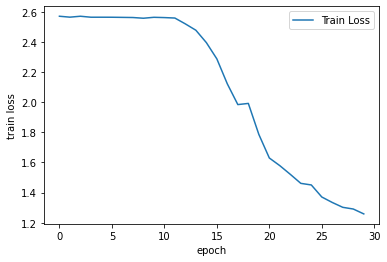

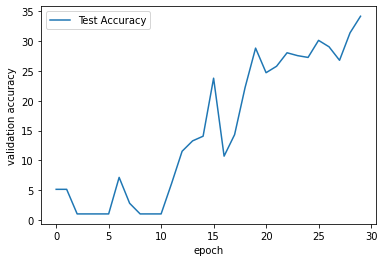

In [56]:
epochs = [i for i in range (30)]
total_train_loss = torch.tensor(total_train_loss, device = 'cpu')
total_train_loss = total_train_loss.numpy()
print(len(total_train_loss))
train_loss = pd.Series(total_train_loss, index = epochs)
train_loss.plot(label='Train Loss')
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.legend()
plt.show()
test_accuracy = pd.Series(total_test_acc , index = epochs)
test_accuracy.plot(label = 'Test Accuracy')
plt.xlabel("epoch")
plt.ylabel("validation accuracy")
plt.legend()
plt.show()

# True positive:

In [105]:
test_iter = iter(test_loader)


In [118]:
im1,lb1 = next(test_iter)

In [119]:
im2 = im1[0].permute(1,2,0)
im2 = im2.numpy()/255

In [120]:
with torch.no_grad():
  prediction = model(im1[:].float().to('cuda'))
prediction = prediction.argmax(dim=1 , keepdim=True)
pred = prediction.cpu().numpy()[0][0]

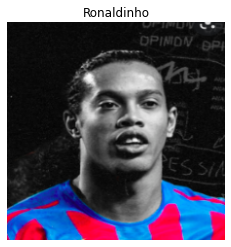

In [121]:
plt.title(labels[pred])
plt.axis('off')
plt.imshow(im2)

# False Negative

In [110]:
im3,lbl3 = next(test_iter)

In [111]:
with torch.no_grad():
  prediction2 = model(im3[:].float().to('cuda'))
prediction2 = prediction2.argmax(dim=1 , keepdim=True)
pred2 = prediction2.cpu().numpy()[0][0]

In [112]:
im3 = im3[0].permute(1,2,0)
im3 = im3.numpy()/255

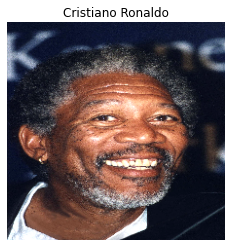

In [113]:
plt.title(labels[pred2])
plt.axis('off')
plt.imshow(im3)

In [14]:
new_test_set = data.test

In [15]:
new_test_loader = DataLoader(new_test_set, batch_size=1, shuffle=False)

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

In [130]:
len(new_test_loader)

52

# Statistics

52it [00:02, 18.59it/s]


              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       1.00      1.00      1.00         3
           4       0.00      0.00      0.00         6
           5       0.33      1.00      0.50         1
           6       0.33      0.25      0.29         4
           7       0.60      0.50      0.55         6
           8       0.25      0.20      0.22         5
           9       0.29      0.50      0.36         4
          10       0.29      1.00      0.44         2
          11       0.50      0.67      0.57         3
          12       0.00      0.00      0.00         7

    accuracy                           0.35        52
   macro avg       0.31      0.43      0.34        52
weighted avg       0.30      0.35      0.31        52



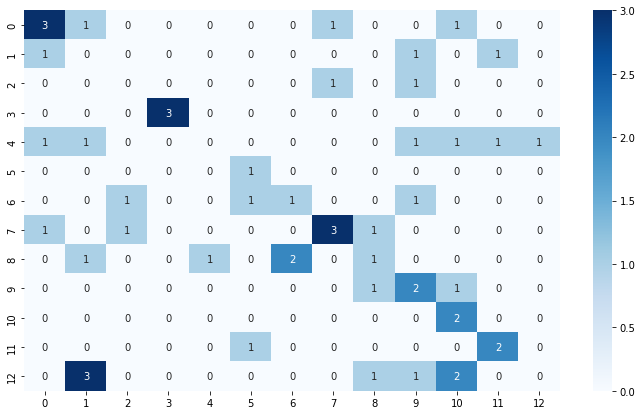

In [131]:
classes= [i for i in range(13)]
validation_loader_for_matrix = new_test_loader
y_true = list()
y_pred = list()
model = model.to('cuda')
model.eval()
for img, lbl in tqdm(validation_loader_for_matrix,total=13):
    y_true.append(lbl[0].long().numpy()) 
    with torch.no_grad():
      prediction = model(img[:].float().to('cuda'))
    prediction = prediction.argmax(dim=1 , keepdim=True)
    y_pred.append(prediction.cpu().numpy()[0][0])
cf_matrix = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix,fmt='.0f', annot=True, cmap='Blues')

In [ ]:
#############################################################################################################################

# Torchvision Models

In [17]:
import torchvision.models as models

Method for retraining models and collecting scores and losses

In [194]:
def retrain_models(model,test_loader,train_loader,loss,model_name,num_epochs):

  opt = torch.optim.Adam(model.parameters(), lr=0.0001)
  train_loss, acc = train_model(model,train_loader,test_loader,opt,loss,num_epoch = num_epochs)

  epochs = [i for i in range (num_epochs)]
  total_train_loss = torch.tensor(train_loss, device = 'cpu')
  total_train_loss = total_train_loss.numpy()
  train_loss = pd.Series(total_train_loss, index = epochs)
  test_accuracy = pd.Series(acc, index = epochs)


  classes= [i for i in range(13)]
  validation_loader_for_matrix = new_test_loader
  y_true = list()
  y_pred = list()
  model.eval()
  print("before")
  for img, lbl in tqdm(validation_loader_for_matrix,total=13):
    y_true.append(lbl[0].long().numpy()) 
    with torch.no_grad():
      prediction = model(img[:].float().to('cuda'))
    y_pred.append(prediction[0].cpu().numpy())




  
  return train_loss,test_accuracy,y_true,y_pred
  


In [20]:
def show_plots(total_train_loss,total_test_accuracy,names_list):
  for i in range(len(total_train_loss)):
    total_train_loss[i].plot(label = names_list[i])
  
  plt.xlabel('epoch')
  plt.ylabel('train loss')
  plt.legend()
  plt.show()
  for i in range(len(total_test_accuracy)):
    total_test_accuracy[i].plot(label=names_list[i])
  plt.xlabel('epoch')
  plt.ylabel('validation accuracy')
  plt.legend()
  plt.show()



**ResNet Model**</br>
Re-training pytorch's ResNet model. In row #2 below we modify the final FC layer to fit the number of our classes (13)


In [245]:
all_models = models.resnet18(pretrained = True)
all_models.fc = nn.Linear(512, 13)

In [246]:
resnet_train_loss,resnet_test_acc,resnet_y_true,resnet_y_pred = retrain_models(all_models,test_loader,train_loader,loss,'ResNet',30)

EPOCH #1


train loss = 2.135662317276001: 100%|██████████| 13/13 [00:04<00:00,  2.77it/s]
accuracy 44.23 percentage || Correct 23 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


EPOCH #2


train loss = 0.7658329010009766: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
accuracy 71.15 percentage || Correct 37 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


EPOCH #3


train loss = 0.3350180983543396: 100%|██████████| 13/13 [00:04<00:00,  2.78it/s]
accuracy 71.15 percentage || Correct 37 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]


EPOCH #4


train loss = 0.16499026119709015: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


EPOCH #5


train loss = 0.10021556168794632: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


EPOCH #6


train loss = 0.06296144425868988: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


EPOCH #7


train loss = 0.05291952192783356: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


EPOCH #8


train loss = 0.04043328016996384: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


EPOCH #9


train loss = 0.033310070633888245: 100%|██████████| 13/13 [00:04<00:00,  2.71it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


EPOCH #10


train loss = 0.02080233208835125: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


EPOCH #11


train loss = 0.021399615332484245: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.64it/s]


EPOCH #12


train loss = 0.019873669371008873: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


EPOCH #13


train loss = 0.01764962449669838: 100%|██████████| 13/13 [00:04<00:00,  2.82it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


EPOCH #14


train loss = 0.016531379893422127: 100%|██████████| 13/13 [00:04<00:00,  2.87it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


EPOCH #15


train loss = 0.013739758171141148: 100%|██████████| 13/13 [00:04<00:00,  2.88it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


EPOCH #16


train loss = 0.011361886747181416: 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


EPOCH #17


train loss = 0.010207544080913067: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


EPOCH #18


train loss = 0.011849201284348965: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
accuracy 82.69 percentage || Correct 43 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


EPOCH #19


train loss = 0.00904650054872036: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


EPOCH #20


train loss = 0.010048170574009418: 100%|██████████| 13/13 [00:04<00:00,  2.72it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


EPOCH #21


train loss = 0.009814701043069363: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]
accuracy 82.69 percentage || Correct 43 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


EPOCH #22


train loss = 0.010217024013400078: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
accuracy 82.69 percentage || Correct 43 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


EPOCH #23


train loss = 0.01057739183306694: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
accuracy 82.69 percentage || Correct 43 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


EPOCH #24


train loss = 0.010966950096189976: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


EPOCH #25


train loss = 0.010941830463707447: 100%|██████████| 13/13 [00:04<00:00,  2.83it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


EPOCH #26


train loss = 0.007297658361494541: 100%|██████████| 13/13 [00:04<00:00,  2.74it/s]
accuracy 82.69 percentage || Correct 43 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


EPOCH #27


train loss = 0.008080780506134033: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]


EPOCH #28


train loss = 0.009059960953891277: 100%|██████████| 13/13 [00:04<00:00,  2.86it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


EPOCH #29


train loss = 0.009662163443863392: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


EPOCH #30


train loss = 0.008198282681405544: 100%|██████████| 13/13 [00:04<00:00,  2.73it/s]
accuracy 82.69 percentage || Correct 43 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


before


52it [00:01, 46.85it/s]


**AlexNet Model**  \
Re-training pytorch's AlexNet model. In row #2 below we modify the final FC layer to fit the number of our classes (13)


In [247]:
all_models = models.alexnet(pretrained=True)
all_models.classifier[6] = nn.Linear(4096,13)

In [248]:
alexnet_train_loss,alexnet_test_acc,alexnet_y_true,alexnet_y_pred = retrain_models(all_models,test_loader,train_loader,loss,'AlexNet',30)

EPOCH #1


train loss = 14.038252830505371: 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]
accuracy 1.92 percentage || Correct 1 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


EPOCH #2


train loss = 3.1973302364349365: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]
accuracy 26.92 percentage || Correct 14 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


EPOCH #3


train loss = 1.8066926002502441: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]
accuracy 28.85 percentage || Correct 15 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


EPOCH #4


train loss = 1.139932632446289: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]
accuracy 28.85 percentage || Correct 15 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


EPOCH #5


train loss = 0.9556914567947388: 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]
accuracy 38.46 percentage || Correct 20 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


EPOCH #6


train loss = 0.5763229131698608: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]
accuracy 34.62 percentage || Correct 18 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


EPOCH #7


train loss = 0.5337518453598022: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]
accuracy 34.62 percentage || Correct 18 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


EPOCH #8


train loss = 0.3536462187767029: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


EPOCH #9


train loss = 0.23269802331924438: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]
accuracy 44.23 percentage || Correct 23 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


EPOCH #10


train loss = 0.1805981993675232: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]
accuracy 46.15 percentage || Correct 24 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


EPOCH #11


train loss = 0.14480090141296387: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]
accuracy 40.38 percentage || Correct 21 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


EPOCH #12


train loss = 0.09276729822158813: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


EPOCH #13


train loss = 0.07025788724422455: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


EPOCH #14


train loss = 0.2133389711380005: 100%|██████████| 13/13 [00:04<00:00,  2.76it/s]
accuracy 44.23 percentage || Correct 23 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


EPOCH #15


train loss = 0.11778552085161209: 100%|██████████| 13/13 [00:04<00:00,  2.94it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


EPOCH #16


train loss = 0.03860689327120781: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]
accuracy 48.08 percentage || Correct 25 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


EPOCH #17


train loss = 0.03935128450393677: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


EPOCH #18


train loss = 0.02441509999334812: 100%|██████████| 13/13 [00:04<00:00,  2.95it/s]
accuracy 34.62 percentage || Correct 18 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


EPOCH #19


train loss = 0.030735205858945847: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]
accuracy 38.46 percentage || Correct 20 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


EPOCH #20


train loss = 0.011205782182514668: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]
accuracy 38.46 percentage || Correct 20 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


EPOCH #21


train loss = 0.030431363731622696: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]
accuracy 36.54 percentage || Correct 19 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


EPOCH #22


train loss = 0.007613516878336668: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]
accuracy 36.54 percentage || Correct 19 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


EPOCH #23


train loss = 0.026370862498879433: 100%|██████████| 13/13 [00:04<00:00,  2.97it/s]
accuracy 36.54 percentage || Correct 19 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


EPOCH #24


train loss = 0.008124096319079399: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


EPOCH #25


train loss = 0.01716621406376362: 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]
accuracy 46.15 percentage || Correct 24 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


EPOCH #26


train loss = 0.009731910191476345: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s]
accuracy 46.15 percentage || Correct 24 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


EPOCH #27


train loss = 0.02625611051917076: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]
accuracy 44.23 percentage || Correct 23 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


EPOCH #28


train loss = 0.007648447062820196: 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]
accuracy 38.46 percentage || Correct 20 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]


EPOCH #29


train loss = 0.0072357808239758015: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s]
accuracy 38.46 percentage || Correct 20 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


EPOCH #30


train loss = 0.008474239148199558: 100%|██████████| 13/13 [00:04<00:00,  3.11it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


before


52it [00:00, 58.96it/s]


**EfficientNet Model** \
Re-training pytorch's EfficientNetb7 model. In box #250 below we modify the final FC layer to fit the number of our classes (13)

In [249]:
all_models = models.efficientnet_b7(pretrained = True)

In [250]:
all_models.classifier = nn.Sequential(
    nn.Dropout(p=0.5,inplace = True),
    nn.Linear(in_features = 2560, out_features = 13, bias = True)
)

In [251]:
efficientnet_train_loss,efficientnet_test_acc,efficientnet_y_true,efficientnet_y_pred = retrain_models(all_models,test_loader,train_loader,loss,'EfficientNet',30)

EPOCH #1


train loss = 2.5037944316864014: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]
accuracy 3.85 percentage || Correct 2 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


EPOCH #2


train loss = 2.0985515117645264: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]
accuracy 3.85 percentage || Correct 2 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.45it/s]


EPOCH #3


train loss = 1.6529524326324463: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 17.31 percentage || Correct 9 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


EPOCH #4


train loss = 1.1669886112213135: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 26.92 percentage || Correct 14 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


EPOCH #5


train loss = 0.7964264154434204: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]
accuracy 38.46 percentage || Correct 20 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


EPOCH #6


train loss = 0.4834362864494324: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 46.15 percentage || Correct 24 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


EPOCH #7


train loss = 0.2938498556613922: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 55.77 percentage || Correct 29 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


EPOCH #8


train loss = 0.1781364232301712: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 67.31 percentage || Correct 35 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


EPOCH #9


train loss = 0.12492963671684265: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 71.15 percentage || Correct 37 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


EPOCH #10


train loss = 0.086275115609169: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


EPOCH #11


train loss = 0.06309164315462112: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


EPOCH #12


train loss = 0.05867199972271919: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


EPOCH #13


train loss = 0.053104277700185776: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


EPOCH #14


train loss = 0.04463783651590347: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]
accuracy 82.69 percentage || Correct 43 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


EPOCH #15


train loss = 0.036991339176893234: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 84.62 percentage || Correct 44 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


EPOCH #16


train loss = 0.02905583567917347: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]
accuracy 88.46 percentage || Correct 46 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


EPOCH #17


train loss = 0.028815947473049164: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


EPOCH #18


train loss = 0.023345397785305977: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


EPOCH #19


train loss = 0.017920812591910362: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


EPOCH #20


train loss = 0.023960206657648087: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 84.62 percentage || Correct 44 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


EPOCH #21


train loss = 0.014350993558764458: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


EPOCH #22


train loss = 0.018294259905815125: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


EPOCH #23


train loss = 0.019918540492653847: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 88.46 percentage || Correct 46 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


EPOCH #24


train loss = 0.028648588806390762: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


EPOCH #25


train loss = 0.015182244591414928: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


EPOCH #26


train loss = 0.022189484909176826: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


EPOCH #27


train loss = 0.01854701340198517: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]
accuracy 88.46 percentage || Correct 46 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


EPOCH #28


train loss = 0.02198861911892891: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


EPOCH #29


train loss = 0.01696300320327282: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]
accuracy 88.46 percentage || Correct 46 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


EPOCH #30


train loss = 0.027484852820634842: 100%|██████████| 13/13 [00:11<00:00,  1.08it/s]
accuracy 84.62 percentage || Correct 44 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


before


52it [00:03, 17.03it/s]


**GoogleNet Model** \
Re-training pytorch's GoogleNet model. In row #2 below we modify the final FC layer to fit the number of our classes (13)

In [143]:
all_models = models.googlenet(pretrained = True)
all_models.fc = nn.Linear(1024,13)

In [252]:
googlenet_train_loss,googlenet_test_acc,googlenet_y_true,googlenet_y_pred = retrain_models(all_models,test_loader,train_loader,loss,'GoogleNet',30)

EPOCH #1


train loss = 0.022089559584856033: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]
accuracy 84.62 percentage || Correct 44 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


EPOCH #2


train loss = 0.011241110041737556: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]
accuracy 88.46 percentage || Correct 46 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]


EPOCH #3


train loss = 0.017911795526742935: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 90.38 percentage || Correct 47 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


EPOCH #4


train loss = 0.02716095559298992: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 92.31 percentage || Correct 48 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


EPOCH #5


train loss = 0.018963465467095375: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]
accuracy 90.38 percentage || Correct 47 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


EPOCH #6


train loss = 0.008820946328341961: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 88.46 percentage || Correct 46 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


EPOCH #7


train loss = 0.008501138538122177: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 88.46 percentage || Correct 46 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


EPOCH #8


train loss = 0.007264451589435339: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 90.38 percentage || Correct 47 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


EPOCH #9


train loss = 0.0047036889009177685: 100%|██████████| 13/13 [00:11<00:00,  1.08it/s]
accuracy 88.46 percentage || Correct 46 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


EPOCH #10


train loss = 0.01837468519806862: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.44it/s]


EPOCH #11


train loss = 0.00622517429292202: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


EPOCH #12


train loss = 0.004533881321549416: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 84.62 percentage || Correct 44 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


EPOCH #13


train loss = 0.008195399306714535: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]
accuracy 86.54 percentage || Correct 45 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


EPOCH #14


train loss = 0.00896372925490141: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 84.62 percentage || Correct 44 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


EPOCH #15


train loss = 0.0042618946172297: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 84.62 percentage || Correct 44 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


EPOCH #16


train loss = 0.018882403150200844: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]
accuracy 76.92 percentage || Correct 40 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


EPOCH #17


train loss = 0.016636420041322708: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.40it/s]


EPOCH #18


train loss = 0.025799555703997612: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 75.00 percentage || Correct 39 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


EPOCH #19


train loss = 0.008987043984234333: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]
accuracy 75.00 percentage || Correct 39 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


EPOCH #20


train loss = 0.011385301128029823: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 75.00 percentage || Correct 39 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]


EPOCH #21


train loss = 0.01762598380446434: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 71.15 percentage || Correct 37 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


EPOCH #22


train loss = 0.012418366968631744: 100%|██████████| 13/13 [00:11<00:00,  1.08it/s]
accuracy 76.92 percentage || Correct 40 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]


EPOCH #23


train loss = 0.007621982600539923: 100%|██████████| 13/13 [00:12<00:00,  1.08it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


EPOCH #24


train loss = 0.01579292118549347: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


EPOCH #25


train loss = 0.004504688084125519: 100%|██████████| 13/13 [00:11<00:00,  1.09it/s]
accuracy 78.85 percentage || Correct 41 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


EPOCH #26


train loss = 0.004641864914447069: 100%|██████████| 13/13 [00:12<00:00,  1.04it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.32it/s]


EPOCH #27


train loss = 0.0060138278640806675: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 84.62 percentage || Correct 44 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


EPOCH #28


train loss = 0.02979218401014805: 100%|██████████| 13/13 [00:12<00:00,  1.06it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.43it/s]


EPOCH #29


train loss = 0.014158753678202629: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]
accuracy 80.77 percentage || Correct 42 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.33it/s]


EPOCH #30


train loss = 0.01652694121003151: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]
accuracy 82.69 percentage || Correct 43 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]


before


52it [00:02, 17.50it/s]


**VGG16Net Model** \
Re-training pytorch's VGG16 model. In rows 2-9 below we modify the final FC layer to fit the number of our classes (13)

In [253]:
all_models = models.vgg16(pretrained = True)
n_classes = 13
n_inputs = all_models.classifier[6].in_features

all_models.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, n_classes),)

In [254]:
vgg16net_train_loss,vgg16net_test_acc,vgg16net_y_true,vgg16net_y_pred = retrain_models(all_models,test_loader,train_loader,loss,'VGG16Net',30)

EPOCH #1


train loss = 3.2405757904052734: 100%|██████████| 13/13 [00:07<00:00,  1.74it/s]
accuracy 13.46 percentage || Correct 7 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]


EPOCH #2


train loss = 2.5807864665985107: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
accuracy 7.69 percentage || Correct 4 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


EPOCH #3


train loss = 2.5591516494750977: 100%|██████████| 13/13 [00:07<00:00,  1.80it/s]
accuracy 3.85 percentage || Correct 2 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s]


EPOCH #4


train loss = 2.50986647605896: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
accuracy 7.69 percentage || Correct 4 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.94it/s]


EPOCH #5


train loss = 2.4460015296936035: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
accuracy 19.23 percentage || Correct 10 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


EPOCH #6


train loss = 2.31037974357605: 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]
accuracy 21.15 percentage || Correct 11 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


EPOCH #7


train loss = 2.1634860038757324: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
accuracy 25.00 percentage || Correct 13 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


EPOCH #8


train loss = 1.7980715036392212: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]
accuracy 32.69 percentage || Correct 17 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


EPOCH #9


train loss = 1.6943964958190918: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 40.38 percentage || Correct 21 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


EPOCH #10


train loss = 1.5633289813995361: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
accuracy 44.23 percentage || Correct 23 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]


EPOCH #11


train loss = 1.3112131357192993: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.03it/s]


EPOCH #12


train loss = 1.0704536437988281: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
accuracy 38.46 percentage || Correct 20 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.22it/s]


EPOCH #13


train loss = 0.8349276781082153: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
accuracy 38.46 percentage || Correct 20 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.92it/s]


EPOCH #14


train loss = 0.8998624086380005: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 38.46 percentage || Correct 20 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


EPOCH #15


train loss = 0.6984812021255493: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
accuracy 44.23 percentage || Correct 23 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


EPOCH #16


train loss = 0.5531485676765442: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
accuracy 40.38 percentage || Correct 21 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.00it/s]


EPOCH #17


train loss = 0.3150251805782318: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
accuracy 48.08 percentage || Correct 25 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s]


EPOCH #18


train loss = 0.3780861794948578: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
accuracy 44.23 percentage || Correct 23 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.19it/s]


EPOCH #19


train loss = 0.2631668746471405: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


EPOCH #20


train loss = 0.1706295758485794: 100%|██████████| 13/13 [00:07<00:00,  1.71it/s]
accuracy 44.23 percentage || Correct 23 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


EPOCH #21


train loss = 0.10690592229366302: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
accuracy 46.15 percentage || Correct 24 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


EPOCH #22


train loss = 0.0584736168384552: 100%|██████████| 13/13 [00:07<00:00,  1.73it/s]
accuracy 46.15 percentage || Correct 24 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s]


EPOCH #23


train loss = 0.04390360414981842: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]
accuracy 46.15 percentage || Correct 24 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


EPOCH #24


train loss = 0.06667610257863998: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
accuracy 48.08 percentage || Correct 25 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


EPOCH #25


train loss = 0.031472399830818176: 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


EPOCH #26


train loss = 0.06375906616449356: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]
accuracy 44.23 percentage || Correct 23 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


EPOCH #27


train loss = 0.02434198372066021: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
accuracy 42.31 percentage || Correct 22 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.11it/s]


EPOCH #28


train loss = 0.03644254058599472: 100%|██████████| 13/13 [00:07<00:00,  1.76it/s]
accuracy 50.00 percentage || Correct 26 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


EPOCH #29


train loss = 0.01713128201663494: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 50.00 percentage || Correct 26 out of 52 samples: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


EPOCH #30


train loss = 0.02430816926062107: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]
accuracy 46.15 percentage || Correct 24 out of 52 samples: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


before


52it [00:01, 42.85it/s]


In [30]:
torch.cuda.empty_cache()

# Results

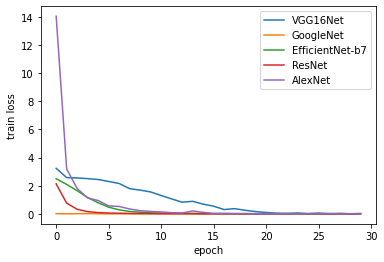

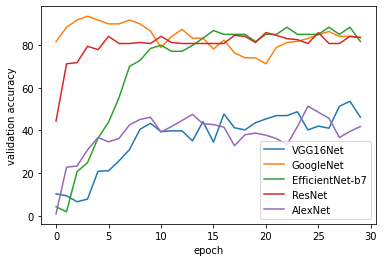

In [255]:
all_models_train_loss = [vgg16net_train_loss,googlenet_train_loss,efficientnet_train_loss,resnet_train_loss,alexnet_train_loss]
all_models_test_acc = [vgg16net_test_acc,googlenet_test_acc,efficientnet_test_acc,resnet_test_acc,alexnet_test_acc]
all_model_names = ['VGG16Net', 'GoogleNet','EfficientNet-b7','ResNet','AlexNet']
show_plots(all_models_train_loss,all_models_test_acc,all_model_names)


We can clearly see that GoogleNet, EfficientNet and ResNet had far better validation accuracy scores, therfore they will have greater weight for the ensambled method in the next part.

# Ensamble

In [256]:
all_y_preds = [resnet_y_pred,googlenet_y_pred,efficientnet_y_pred,vgg16net_y_pred,alexnet_y_pred]

Collecting ensamble predictions:</br>
Each model recieved a weight based on its performance in training.</br>
We will now multiply each model's prediction with the given weight, then sum each image prediction to get an ensambled prediction.

In [257]:
result_weight_list = [0.25,0.25,0.25,0.125,0.125]
ensamble_predict = []
for k in range(52):
  predict = []
  for i in range(13):
    num = 0
    for j in range(5):
      num+=all_y_preds[j][k][i]*result_weight_list[j]   
    predict.append(num)
  predict = predict.index(max(predict))
  ensamble_predict.append(predict)



Measuring the ensambled predicions success:

In [258]:
ensamble_correct_count = 0
counter = 0
for i in ensamble_predict:
  if i == resnet_y_true[counter]:
    ensamble_correct_count+=1
  counter+=1


In [259]:
print(ensamble_correct_count/counter)

0.8846153846153846


Ensambled predictions are 88.4% accurate

In [261]:
avg_total_preds = 0
for i in range(5):
  avg_total_preds+=all_models_test_acc[i][29]
avg_total_preds/=5
print(f"Average total predictions: {avg_total_preds}")

Average total predictions: 67.28766025641025


The average predicion score of the models we selected (independently) is 67.3%.</br>Therefore there is a 21.1% difference in favor of the ensambled predicions.

# Summary

1. Scores:


*   **Our VGG16 Model Accuracy**: 34.62% - a relatively 'low' score, however the model was only trained with 208 images.
*   **ResNet Model Accuracy**: 82.69%
* **EfficientNetb7 Model Accuracy**: 84.62%
* **AlexNet Model Accuracy**: 42.31%
* **VGG16Net Model Accuracy**: 46.15%
* **Average pytorch models accuracy**: 67.3%
* **Ensambled Accuracy**: 88.4%

"The wisdom of the croud": The ensambled results were as we expected, as the more accurate models had a more meaninful prediction to the final result.

2. Difference between our VGG16 and pytorch's VGG16:
* Our model was trained on significantly less data, therefore it was less accurate, however - the margin is not that large: approximately 11.5%.

3. Ensamble method implementation:
* We chose to use this method as we learned it is more accurate than other ensamble methods like average,voting, etc.

